# Conformal classification

We create a synthetic classification dataset with three classes

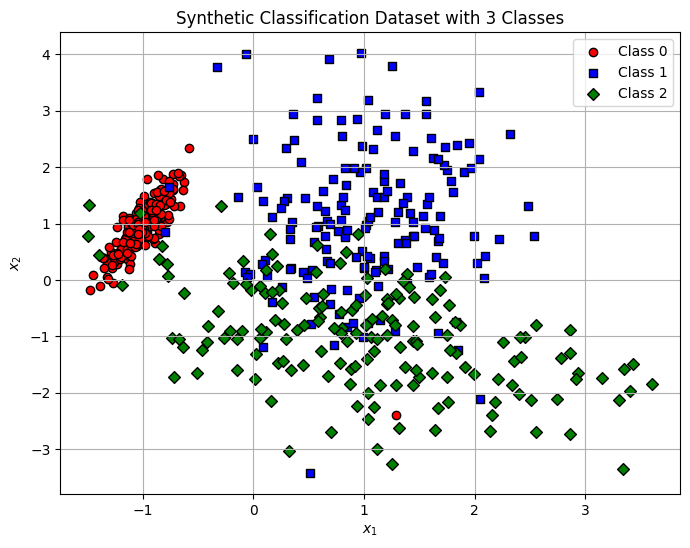

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import numpy as np

N = 500

X, y = make_classification(n_samples=N, n_features=2, n_informative=2, n_redundant=0, 
                           n_classes=3, n_clusters_per_class=1, random_state=2024)


# Create a scatter plot with different symbols for each class
plt.figure(figsize=(8, 6))

# Define different markers for each class
markers = ['o', 's', 'D']
colors = ['red', 'blue', 'green']

# Plot each class with a different marker
for label, marker, color in zip(np.unique(y), markers, colors):
    plt.scatter(X[y == label, 0], X[y == label, 1], label=f'Class {label}', marker=marker, color=color, edgecolor='k')

# Add labels and a legend
plt.title('Synthetic Classification Dataset with 3 Classes')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.grid(True)
plt.show()

Create a conformal predictor and evaluate the running results.

In [2]:
from online_cp import ConformalNearestNeighboursClassifier
from online_cp import Evaluation, Err, OF, OE
cp = ConformalNearestNeighboursClassifier(k=1, label_space=np.unique(y))

metrics = Evaluation(err=Err, oe=OE, of=OF)

for i, (obj, lab) in enumerate(zip(X, y)):
    
    # Make prediction
    Gamma, p_values, D = cp.predict(obj, epsilon=0.1, return_p_values=True, return_update=True) 

    # Learn the label
    cp.learn_one(obj, lab, D)

    metrics.update(y=lab, Gamma=Gamma, p_values=p_values)

Plot the cumulative results

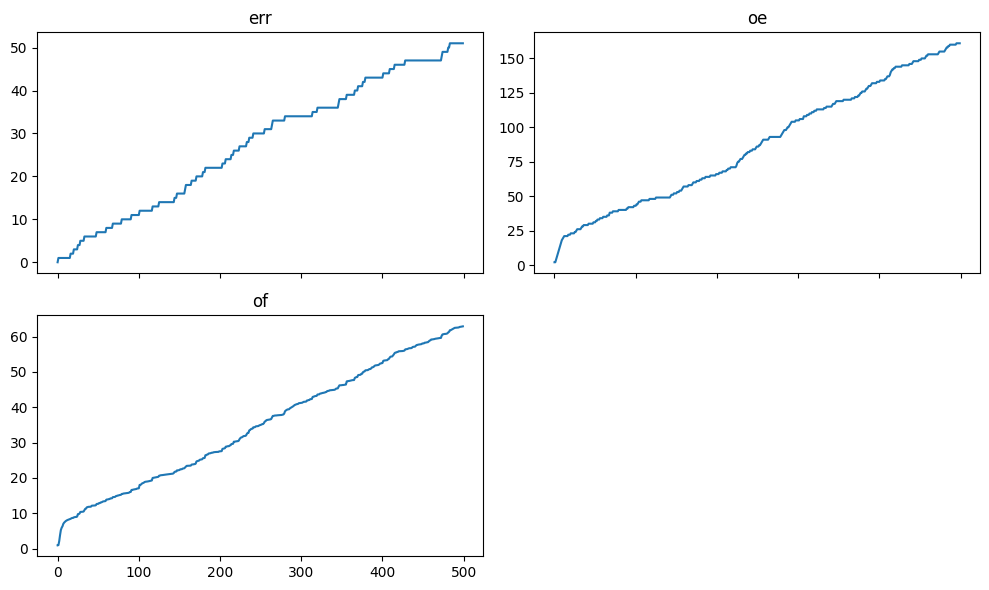

In [3]:
metrics.plot_cumulative_results()

The output is a ConformalPredictionSet. It is represented as an array with the included labels

In [4]:
type(Gamma)

online_cp.classifiers.ConformalPredictionSet

In [5]:
Gamma

array([0])

In [6]:
Gamma.size()

1

# Conformal regression

Create a synthetic dataset

In [7]:
rnd_gen = np.random.default_rng(2024)

N = 500
X = rnd_gen.normal(loc=0, scale=1, size=(N, 4))
beta = np.array([2, 1, 0, 0])
y = X @ beta + rnd_gen.normal(loc=0, scale=1, size=N)

Create a conformal predictor

In [8]:
from online_cp import ConformalRidgeRegressor
from online_cp import WinklerScore, Width

cp = ConformalRidgeRegressor(a=0.001)

metrics = Evaluation(err=Err, winkler=WinklerScore, width=Width)

epsilon = 0.1

# Ensure that we can get informative prediction sets
X_init_train = X[:int(np.ceil(2/epsilon))]
y_init_train = y[:int(np.ceil(2/epsilon))]

X_process = X[int(np.ceil(2/epsilon)):]
y_process = y[int(np.ceil(2/epsilon)):]

cp.learn_initial_training_set(X_init_train, y_init_train)

for obj, lab in zip(X_process, y_process):
    
    # Make prediction
    Gamma, precomputed = cp.predict(obj, epsilon=epsilon, return_update=True) 
    # To avoid repeating computations, we return some precomputed arrays if return_update=True

    # Learn the label
    cp.learn_one(obj, lab, precomputed)
    # We do not have to invert a matrix at each step n. The hat matrix can be efficiently updaten online using the Sherman-Morrison formula

    # Update efficiency criteria
    metrics.update(y=lab, Gamma=Gamma, epsilon=epsilon)

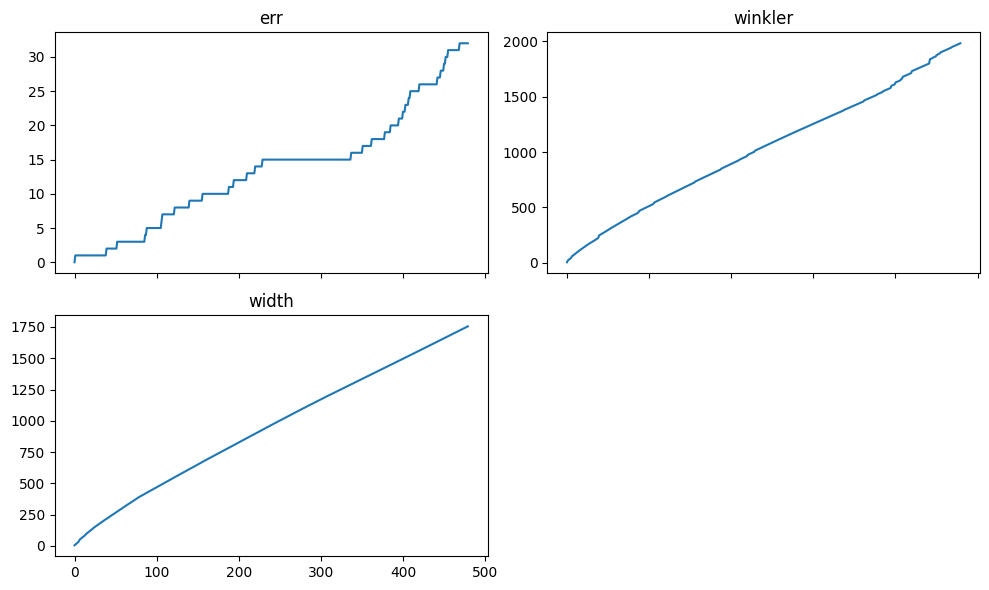

In [9]:
metrics.plot_cumulative_results()

The output of a conformal regressor is a ConformalPredictionInterval, which is represented as a tuple with the interval boundaries.

In [10]:
type(Gamma)

online_cp.regressors.ConformalPredictionInterval

In [11]:
Gamma

(0.9795958885024465, 4.24872526989365)

In [12]:
Gamma.width()

3.2691293813912035

# Conformal predictive system

Define a conformal predictive system, and run it on the synthetic regression dataset

In [13]:
from online_cp import RidgePredictionMachine, CRPS

cps = RidgePredictionMachine(a=0.001)

cps.learn_initial_training_set(X_init_train, y_init_train)

metrics = Evaluation(crps=CRPS)

for obj, lab in zip(X_process, y_process):
    tau = np.random.uniform(0, 1)
    
    # Compute CPD
    cpd, precomputed = cps.predict_cpd(x=obj, return_update=True) 
    # To avoid repeating computations, we return some precomputed arrays if return_update=True

    # Learn the label
    cps.learn_one(x=obj, y=lab, precomputed=precomputed)

    # Update efficiency
    metrics.update(y=lab, cpd=cpd)

The output of a conformal predictive system is a conformal predictive function (CPD), a callable function. To better illustrate its properties, retrain with a smaller training set.

In [14]:
cpd

In [15]:
cps = RidgePredictionMachine(a=0.001)

M = 100
cps.learn_initial_training_set(X=X[:M], y=y[:M])

cpd = cps.predict_cpd(X[M])

Calling a CPD with a potential label outputs the upper and lower value

In [16]:
cpd(y=-2)

(0.0, 0.009900990099009901)

Also passing a random number $\tau$, generated independently form everyhing else, outputs the smoothed p-value of the potential label $y$.

In [17]:
cpd(y=-2, tau=rnd_gen.uniform(0, 1))

0.0036070418036338267

We can illustrate the CPD by plotting the lower and upper distributions

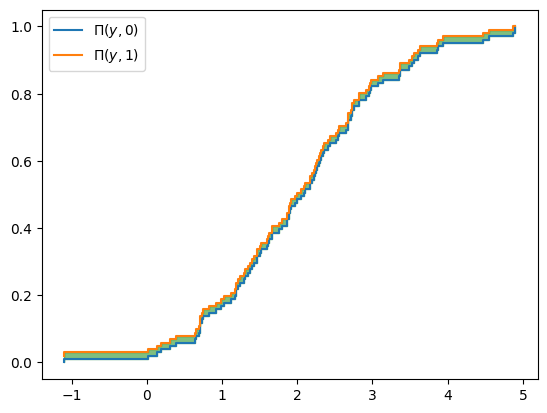

In [18]:
cpd.plot()

Passing a random number $\tau$ plots the convex combination

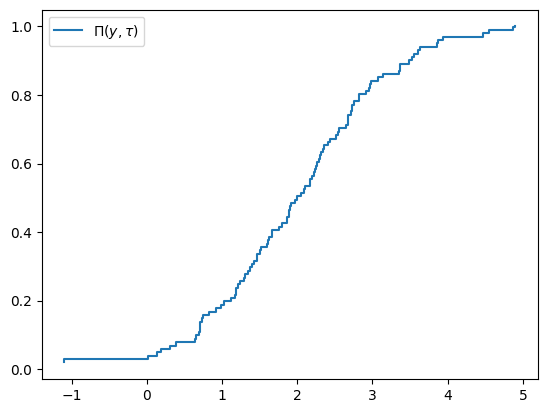

In [19]:
cpd.plot(tau)

A CPD can be used to construct prediction intervals

In [20]:
cpd.predict_set(tau=tau, epsilon=0.1)

(0.3116860787926793, 3.8698097884072857)

We can also optimise the width of the interval

In [21]:
cpd.predict_set(tau=tau, epsilon=0.1, minimise_width=True)

(0.009000558053182952, 3.6322260469735705)

# Testing exchangeability

We create a synhtetic dataset with a change point

In [22]:
beta1 = np.array([2, 1, 0, 0])
beta2 = np.array([0, 0, 1, 2])

Y1 = X[:int(N/2)] @ beta1 + rnd_gen.normal(loc=0, scale=1, size=int(N/2))
Y2 = X[int(N/2):N] @ beta2 + rnd_gen.normal(loc=0, scale=1, size=int(N/2))
y = np.concatenate([Y1, Y2])

# Ensure that we can get informative prediction sets
X_init_train = X[:int(np.ceil(2/epsilon))]
y_init_train = y[:int(np.ceil(2/epsilon))]

X_process = X[int(np.ceil(2/epsilon)):]
y_process = y[int(np.ceil(2/epsilon)):]

In [23]:
from online_cp import PluginMartingale

M = PluginMartingale(warnings=False) # We expect the martingale to grow, and the warnings can be supressed

cp = ConformalRidgeRegressor(a=0.001)

epsilon = 0.1

# Ensure that we can get informative prediction sets
X_init_train = X[:int(np.ceil(2/epsilon))]
y_init_train = y[:int(np.ceil(2/epsilon))]

X_process = X[int(np.ceil(2/epsilon)):]
y_process = y[int(np.ceil(2/epsilon)):]

cp.learn_initial_training_set(X_init_train, y_init_train)

for obj, lab in zip(X_process, y_process):
    
    # Learn the label
    cp.learn_one(obj, lab)#, precomputed)
    
    # Compute the smoothed p-value
    p = cp.compute_p_value(x=obj, y=lab, smoothed=True)

    # Update martingale
    M.update_martingale_value(p)

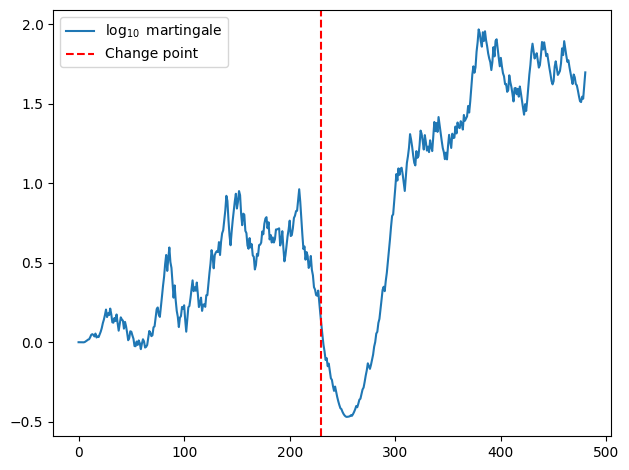

In [28]:
plt.plot(M.log10_martingale_values, label=r'$\log_{10}$ martingale')
plt.axvline(int(N/2) - y_init_train.size, linestyle='--', label='Change point', color='red')
plt.legend()
plt.tight_layout()

# Kernel CRR

The kernel methods are under development.

In [29]:
N = 500
X = rnd_gen.normal(loc=0, scale=1, size=(N, 4))
beta = np.array([2, 1, 0, 0])
y = (X @ beta)**2 + rnd_gen.normal(loc=0, scale=1, size=N)

# Ensure that we can get informative prediction sets
X_init_train = X[:int(np.ceil(2/epsilon))]
y_init_train = y[:int(np.ceil(2/epsilon))]

X_process = X[int(np.ceil(2/epsilon)):]
y_process = y[int(np.ceil(2/epsilon)):]

In [34]:
from online_cp.regressors import KernelConformalRidgeRegressor
from online_cp.kernels import GaussianKernel

ker = GaussianKernel(sigma=1)

kernel_a = 0.001
cp = KernelConformalRidgeRegressor(a=kernel_a, kernel=ker)

cp.learn_initial_training_set(X_init_train, y_init_train)

metrics = Evaluation(err=Err, winkler=WinklerScore, width=Width)

for obj, lab in zip(X_process, y_process):
    # Make prediction
    Gamma, precomputed = cp.predict(obj, epsilon=epsilon, return_update=True) 
    # To avoid repeating computations, we return some precomputed arrays if return_update=True

    # Learn the label
    cp.learn_one(obj, lab, precomputed)
    # We do not have to invert a matrix at each step n. The hat matrix can be efficiently updaten online using the Sherman-Morrison formula
    
    # Update efficiency criteria
    metrics.update(y=lab, Gamma=Gamma, epsilon=epsilon)

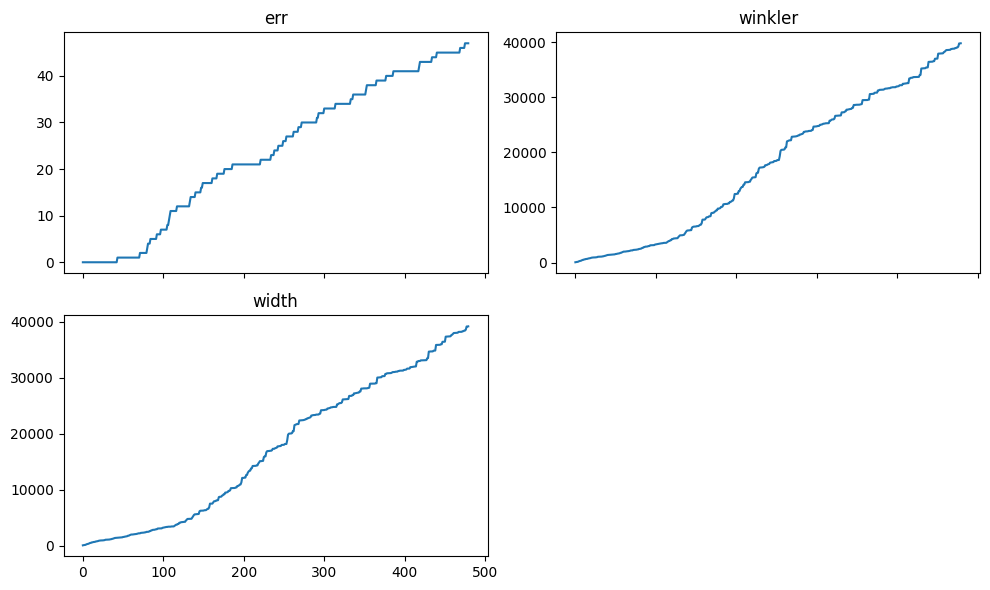

In [35]:
metrics.plot_cumulative_results()